In [2]:
!pip install -q fsspec
!pip install -q gcsfs
!pip install -q geopandas
!pip install -q cartopy
!pip install -q --no-binary shapely shapely --force

In [1]:
import os
import pathlib
from glob import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from datetime import datetime
from dateutil.relativedelta import relativedelta

import scipy.stats as stats

%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as img_tiles

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib
import seaborn as sns
sns.set_theme(style="white")

### functions used for analysis

In [2]:
def read_time_series(path):
    df = pd.read_csv(path, parse_dates=True, index_col=["time"])
    df = df[['area']]
    return df

def compute_aggregated_timeseries_sel(reservoir_ids):
#     filenames = [f'{str(fid).zfill(7)}.csv' for fid in reservoir_ids]
    dfs = []
    if len(reservoir_ids) == 0:
        return
    
    for fid in tqdm(reservoir_ids):
        path = os.path.join(dir_monthly_timeseries, f'{str(fid).zfill(7)}.csv')

#     for f in tqdm(filenames):
#         path = dir_monthly_timeseries + f
        
        # if not path.exists():
        #     print(f'Warning, time series does not exist: {path.name}')
        #     continue
        df = read_time_series(path)
        df.rename(columns={"area": f"area_{fid}"}, inplace=True)
        dfs.append(df)
#     df = dfs[0]
#     for i, df_ in tqdm(enumerate(dfs[1:]), total=len(dfs)-1):
# #         df = df.join(df_, how='outer', rsuffix=f'_{i}')
#         df = df.join(df_, how='outer')
    df_all = pd.concat(dfs, axis=1)
#     df['area'] = df.sum(axis=1)
    df = df_all.sum(axis=1)
#     df.to_csv(out_dir_monthly_timeseries_by_country / f'{country_code}.csv')
    
    return df, df_all

def fit(ts, dist='gamma', include_zero=True):
    """
    This function fits a distribution (e.g. default gamma, but can be altered to 
    genextreme, normal, or other supported by scipy.stats) from a number of samples. It can (should) be tested
    whether the process fits chosen distribution, e.g. with a goodness of fit or Q-Q plots.
    Input:
        samples            : the samples from the process, to be described by
                             the Gamma distribution
        dist:              : chosen distribution, compatible with scipy.stats
        include_zero       : Default: True, decide if probability of zero values occurring should be included 
                             explicitly
    Output:
        fit_params         : tuple with fit parameters of chosen distribution such as shape, location, scale
        prob_zero          : the probability of zero occurring (if relevant)

    """

    samples = ts.values.flatten()  # flatten the matrix to a one-dimensional array
    if include_zero:
        # compute probability of zero rainfall
        prob_zero = float(sum(samples == 0)) / len(samples)
    else:
        prob_zero = 0.
    # find the amount of samples
    n = len(samples)
    # select the gamma distribution function to work with
    dist_func = getattr(stats, dist)
    # fit parameters of chosen distribution function, only through non-zero samples
    if include_zero:
        fit_params = dist_func.fit(samples[(samples != 0) & np.isfinite(samples)])
    else:
        fit_params = dist_func.fit(samples[np.isfinite(samples)])
    # following is returned from the function
    return fit_params, prob_zero

def quantile_trans(ts, fit_params, p_zero, dist='gamma'):
    """
    This function detrermines the normal quantile transform of a number of samples, based on
    a known (e.g. Gamma) distribution of the process (can in principle
    be extended to support grids instead of point values)
    Input:
        samples            : the samples from the process, for which standardized index is
                             computed
        fit_params         : the distribution parameters (need to be of expected size for given distribution)
        loc                : the location (mean) parameter of the distribution
        beta               : the scale parameter of the distribution
        prob_zero          : the probability of zero-rainfall
        dist:              : chosen distribution, compatible with scipy.stats
    Output:
        standardized       : Standardized values of the given samples
    """
    # compute probability of underspending of given sample(s), given the predefined Gamma distribution
    samples = ts.values
    # find zero samples
    if p_zero > 0:
        ii = samples == 0
    # find missings in samples
    jj = np.isnan(samples)
    # get the requested distribution
    dist_func = getattr(stats, dist)
    # compute the cumulative distribution function quantile values using the fitted parameters
    cdf_samples = dist_func.cdf(samples, *fit_params)
    # correct for no rainfall probability
    cdf_samples = p_zero + (1 - p_zero) * cdf_samples
    if p_zero > 0:
        cdf_samples[ii] = p_zero
    cdf_samples[jj] = np.nan
    # compute inverse normal distribution with mu=0 and sigma=1, this yields the SPI value. 
    # Basically this means looking up how many standard deviations the given quantile represents in 
    # a normal distribution with mu=0. and sigma=1.
    standardized = stats.norm.ppf(cdf_samples)
    return standardized

def fit_and_transform(samples, dist='gamma', include_zero=True):
    # The function below fits the samples to the requested distribution 'gamma' or 'genextreme', or other scipy.stats
    fit_params, p_zero = fit(samples, dist=dist, include_zero=include_zero)
    # Then the fitted parameters are used to estimate the SPI for each invidual month
    spi_samples = quantile_trans(samples, fit_params, p_zero, dist=dist)
    # finally, the spi samples are put into a pandas timeseries again, so that we can easily make time series plots
    # and do further analyses
    return pd.Series(spi_samples, index=samples.index)

def compute_standard_index(ts, index='time.month', dist='gamma', include_zero=True):
    """
    Compute standardised index (e.g. SPI, SPEI). This is done on monthly time series by:
    - grouping the monthly data into monthly bins
    - for each month fit a distribution function (gamma or gev)
    - estimate the probability of exceedance of each point in the time series using the 12 distributions
    - estimate the normal transform of each probability found using mapping to a standard normal distribution
    Input:
        ts: pandas Series object containing monthly data (e.g. monthly precipitation, precip-ref. evaporation)
        index='time.month': index to use for grouping
        dist='gamma': distribution to use. Currently implemented are 'gamma' (default) and 'gev'.
    """
    # first, we group all values per month. So we get a group of January rainfalls, February rainfalls, etc.
    ts_group = ts.groupby(index)
    # for each group, the SPI values are computed and coerced into a new time series. 
    spi = ts_group.apply(fit_and_transform, dist=dist, include_zero=include_zero)
    return spi

## Read shapefile with representation of all relevant points

WARNING: copy data files from supplementary materials before running the cells below

In [3]:
dir_monthly_timeseries = 'time_series/time_series_area_monthly/'
# dir_monthly_timeseries = r'gs://global-water-watch/wps-reservoir-time-series-latest/time_series_area_monthly/'

In [4]:
# !cp -R /content/drive/MyDrive/Research/Papers/2022.XX\ Global\ reservoir\ surface\ area\ dynamics/submission/v1/supplementary/time_series ./

In [ ]:
!unzip ./time_series/time_series_area_monthly.zip -d ./time_series

In [ ]:
!gsutil -m -q cp -R gs://global-water-watch/shp ./

In [ ]:
!ls shp

extra					reservoirs-locations-v1.0.prj
reservoirs-locations-v1.0.cpg		reservoirs-locations-v1.0.shp
reservoirs-locations-v1.0.dbf		reservoirs-locations-v1.0.shx
reservoirs-locations-v1.0-dynamics.cpg	reservoirs-v1.0.dbf
reservoirs-locations-v1.0-dynamics.dbf	reservoirs-v1.0.prj
reservoirs-locations-v1.0-dynamics.prj	reservoirs-v1.0.qix
reservoirs-locations-v1.0-dynamics.shp	reservoirs-v1.0.shp
reservoirs-locations-v1.0-dynamics.shx	reservoirs-v1.0.shx


In [5]:
reservoirs = gpd.read_file(r'shp/extra/reservoirs-v1.0-and-countries-basins.shp')

In [6]:
reservoirs.fillna(value=-9999, inplace=True)
reservoirs = reservoirs[reservoirs.basin_id != -9999]

In [7]:
reservoirs.fid = reservoirs.fid.astype(int)
reservoirs.basin_id = reservoirs.basin_id.astype(int)

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### filter out reservoirs in Southern Africa and plot on a map

In [8]:
reservoirs_sel = reservoirs[reservoirs["country_co"] == "SF"]
reservoirs_sel


,fid,mean,median,sd_intra,sd_inter,rsd_intra,rsd_inter,basin_id,basin_name,country_co,country_na,geometry
13364,34,3.111217e+03,2.889558e+03,5.825452e+02,9.875439e+02,0.187240,0.317414,7008,Orange,SF,South Africa,POINT (29.34796 -26.75578)
13365,360,1.374545e+04,1.393111e+04,1.224819e+03,1.892791e+03,0.089107,0.137703,7008,Orange,SF,South Africa,POINT (26.94838 -27.21931)
13366,445,5.701789e+03,5.817089e+03,1.243052e+03,1.396330e+03,0.218011,0.244893,7008,Orange,SF,South Africa,POINT (26.21392 -29.05188)
13367,573,5.104471e+03,4.811818e+03,1.074480e+03,1.228002e+03,0.210498,0.240574,7008,Orange,SF,South Africa,POINT (28.15069 -28.71267)
13368,617,7.072984e+03,7.716490e+03,1.507361e+03,1.962798e+03,0.213115,0.277506,7008,Orange,SF,South Africa,POINT (27.23512 -30.71987)
...,...,...,...,...,...,...,...,...,...,...,...,...
57404,85903,1.705037e+07,1.806845e+07,5.881152e+05,1.969180e+06,0.034493,0.115492,7007,Limpopo,SF,South Africa,POINT (27.86679 -25.75006)
57405,85931,1.232032e+07,1.197507e+07,7.222125e+05,4.508554e+06,0.058620,0.365944,7007,Limpopo,SF,South Africa,POINT (29.43036 -24.79704)
57406,86753,2.083620e+07,2.242776e+07,1.008706e+06,2.913295e+06,0.048411,0.139819,7007,Limpopo,SF,South Africa,POINT (29.31560 -25.43119)
57407,86960,1.663895e+07,1.558422e+07,1.355263e+06,6.659143e+06,0.081451,0.400214,7007,Limpopo,SF,South Africa,POINT (26.45359 -24.89327)


/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


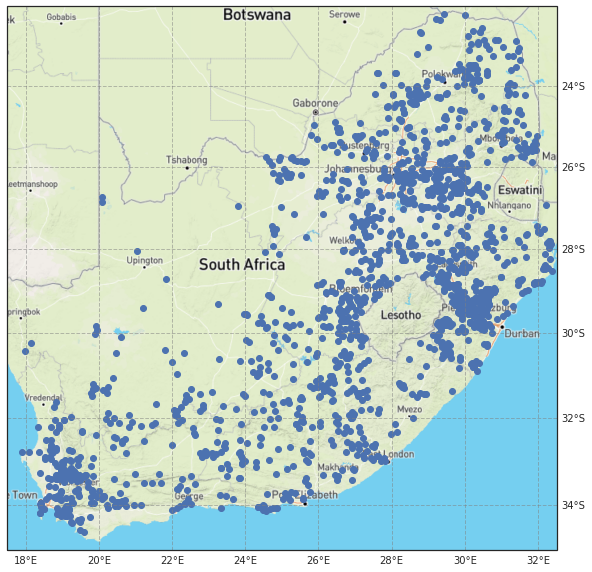

In [15]:
from matplotlib.collections import LineCollection
token = 'pk.eyJ1IjoiaGN3aW5zZW1pdXMiLCJhIjoiY2l2MHd3aDN4MDA0OTJ6dDU2Y2F6MWk0dCJ9.mLH0b46r4cHNdb1w9-dLcQ'
outdoor = img_tiles.MapboxStyleTiles(token, 'hcwinsemius', 'ck4ohy7u59mfg1cmi0z2twtll')

f = plt.figure(figsize=(18, 10))
ax = plt.subplot(111, projection=outdoor.crs)
ax.set_extent([17.5, 32.5, -35, -22], crs=ccrs.PlateCarree())
ax.add_image(outdoor, 6, interpolation='bilinear')
reservoirs_sel.plot(ax=ax, transform=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

Zoom in to Western Cape area and show reservoirs inc their size

In [16]:
AREA_THRES = 1e6
 
bounds_large = (17.5, 21.5, -35, -32)
bounds_small = (18.25, 19.5, -34.5, -33.5)

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


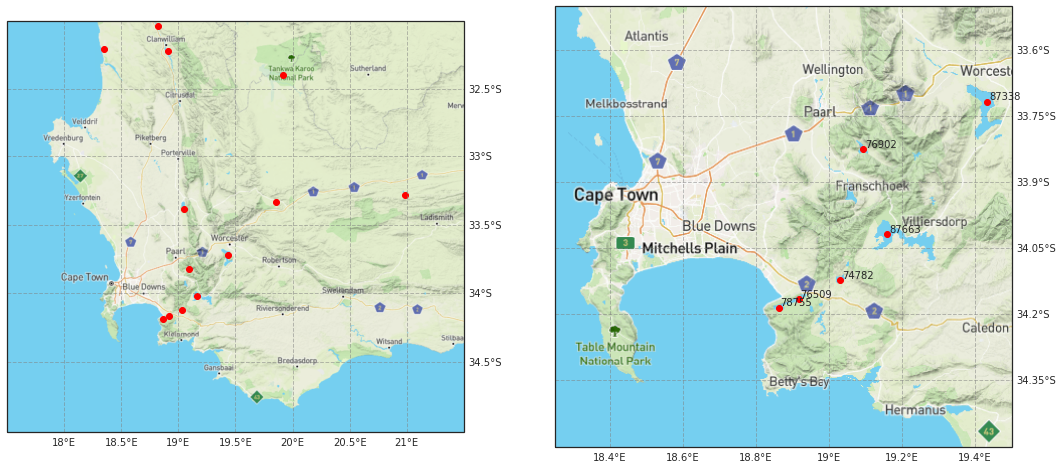

In [17]:
from matplotlib.collections import LineCollection
token = 'pk.eyJ1IjoiaGN3aW5zZW1pdXMiLCJhIjoiY2l2MHd3aDN4MDA0OTJ6dDU2Y2F6MWk0dCJ9.mLH0b46r4cHNdb1w9-dLcQ'
outdoor = img_tiles.MapboxStyleTiles(token, 'hcwinsemius', 'ck4ohy7u59mfg1cmi0z2twtll')
f = plt.figure(figsize=(18, 10))
ax = plt.subplot(121, projection=outdoor.crs)
ax.set_extent(bounds_large, crs=ccrs.PlateCarree())
ax.add_image(outdoor, 8, interpolation='bilinear')
reservoirs_sel[reservoirs_sel["mean"] > AREA_THRES].plot(ax=ax, transform=ccrs.PlateCarree(), color='red')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax = plt.subplot(122, projection=outdoor.crs)
ax.set_extent(bounds_small, crs=ccrs.PlateCarree())
ax.add_image(outdoor, 9, interpolation='bilinear')
reservoirs_sel[reservoirs_sel["mean"] > AREA_THRES].plot(ax=ax, transform=ccrs.PlateCarree(), color='red')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

# plt.text(, 'New York',
#          horizontalalignment='right',
#          transform=ccrs.PlateCarree())
xmin, xmax, ymin, ymax = bounds_small
for n, r in reservoirs_sel[reservoirs_sel["mean"] > AREA_THRES].iterrows():
    g = r["geometry"]
    if ((g.x > xmin) & (g.x < xmax)) & ((g.y > ymin) & (g.y < ymax)):
        ax.text(g.x+0.0051, g.y+0.005, r["fid"], transform=ccrs.PlateCarree())

gl.xlabels_top = False
gl.ylabels_left = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


In [18]:
print(len(reservoirs_sel[reservoirs_sel["mean"] > AREA_THRES]))
print(len(reservoirs_sel))

168
1933


### filter on bounding box and plot total storage time series

In [19]:
xmin, xmax, ymin, ymax = bounds_small
cape = reservoirs_sel[reservoirs_sel["mean"] > AREA_THRES]
cape = cape[cape.geometry.x < xmax]
cape = cape[cape.geometry.x > xmin]
cape = cape[cape.geometry.y > ymin]
cape = cape[cape.geometry.y < ymax]
reservoir_ids = cape.fid.values
reservoir_ids
df, df_all = compute_aggregated_timeseries_sel(reservoir_ids)


  0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
cape

,fid,mean,median,sd_intra,sd_inter,rsd_intra,rsd_inter,basin_id,basin_name,country_co,country_na,geometry
44512,87338,3.335460e+07,3.420127e+07,2.551921e+06,1.965752e+06,0.076509,0.058935,7016,"South Africa, South Coast",SF,South Africa,POINT (19.43359 -33.71756)
44513,87663,3.795996e+07,4.112951e+07,3.394058e+06,6.887835e+06,0.089412,0.181450,7016,"South Africa, South Coast",SF,South Africa,POINT (19.16008 -34.01947)
57104,74782,2.036064e+06,2.099426e+06,2.116587e+05,1.103170e+05,0.103955,0.054181,7024,"South Africa, West Coast",SF,South Africa,POINT (19.03014 -34.12318)
57105,76509,2.352703e+06,2.439221e+06,2.155048e+05,1.424362e+05,0.091599,0.060542,7024,"South Africa, West Coast",SF,South Africa,POINT (18.91740 -34.16585)
57106,76902,2.341444e+06,2.333929e+06,2.698904e+05,1.965560e+05,0.115267,0.083946,7024,"South Africa, West Coast",SF,South Africa,POINT (19.09347 -33.82584)
57107,78755,2.912446e+06,2.963238e+06,3.592383e+05,2.314200e+05,0.123346,0.079459,7024,"South Africa, West Coast",SF,South Africa,POINT (18.86215 -34.18516)


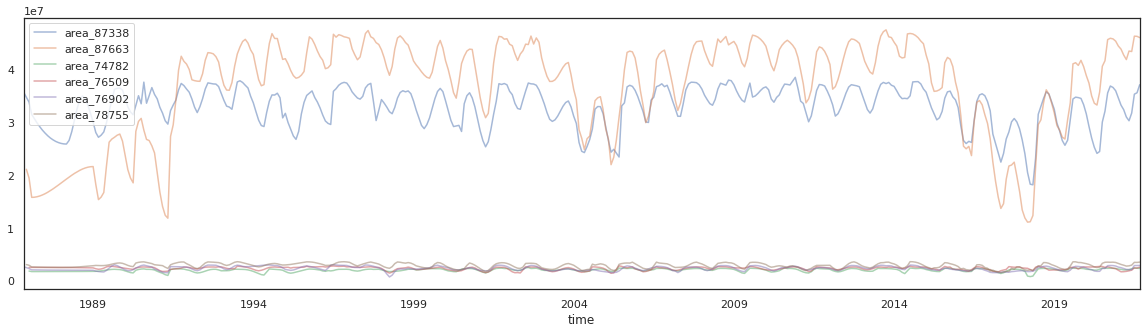

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
df_all.plot(ax=ax, alpha=0.5)
# country_codes = reservoirs_and_country_basin.country_co.unique()
# for i in tqdm(country_codes):
#     compute_aggreated_timeseries_country(i)

## compute Standardized Area Index
Compute Standardized Area Index for all selected, using the scripts of hydrology 2 lectures

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


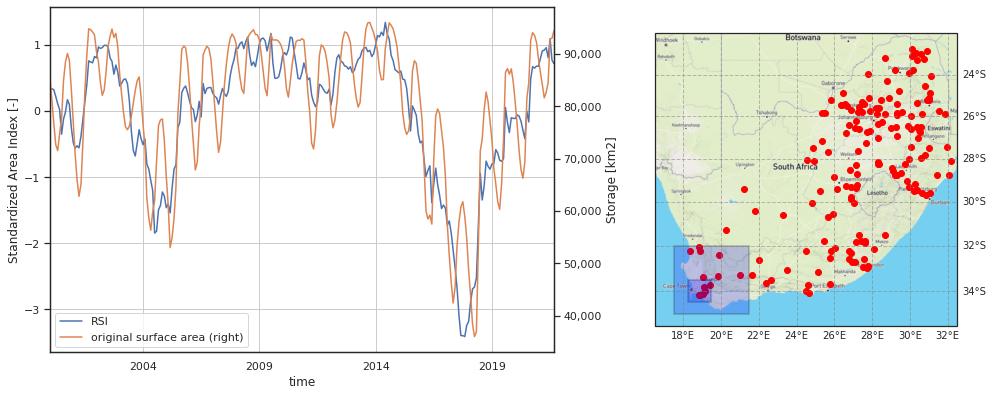

In [23]:
area = df["2000-01-01":]/1000
SSI = compute_standard_index(area, index=area.index.month, include_zero=False, dist="norm")
f = plt.figure(figsize=(14, 6))
ax = f.add_axes([0.1, 0.1, 0.5, 0.8])
SSI.plot(ax=ax, label="RSI")
area.plot(ax=ax, secondary_y=True, label="original surface area")

lines = ax.get_lines() + ax.right_ax.get_lines()
ax.legend(lines, [l.get_label() for l in lines])
ax.set_ylabel("Standardized Area Index [-]")
ax.right_ax.set_ylabel("Storage [km2]")

ax.right_ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid()
ax2 = f.add_axes([0.7, 0, 0.3, 1], projection=outdoor.crs)

bounds_large = (17.5, 21.5, -35, -32)
bounds_small = (18.25, 19.5, -34.5, -33.5)
ax2.set_extent([16.5, 32.5, -35.5, -22], crs=ccrs.PlateCarree())
ax2.add_image(outdoor, 6, interpolation='bilinear')
reservoirs_sel[reservoirs_sel["mean"] > AREA_THRES].plot(ax=ax2, transform=ccrs.PlateCarree(), color='red')
xmin, xmax, ymin, ymax = bounds_small
ax2.add_patch(
    mpatches.Rectangle(
        xy=[xmin, ymin], width=xmax-xmin, height=ymax-ymin,
        facecolor='blue',alpha=0.2,
        transform=ccrs.PlateCarree(),
        edgecolor="k",
        linewidth=2.,
    )
)
xmin, xmax, ymin, ymax = bounds_large
ax2.add_patch(
    mpatches.Rectangle(
        xy=[xmin, ymin], width=xmax-xmin, height=ymax-ymin,
        facecolor='blue',alpha=0.2,
        transform=ccrs.PlateCarree(),
        edgecolor="k",
        linewidth=2.,
    )
)


gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# plt.legend(ax)

### Day zero analysis

Check if SSI for unique reservoir Theewaterskloof is different from direct surrounding reservoirs, and of larger radius


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


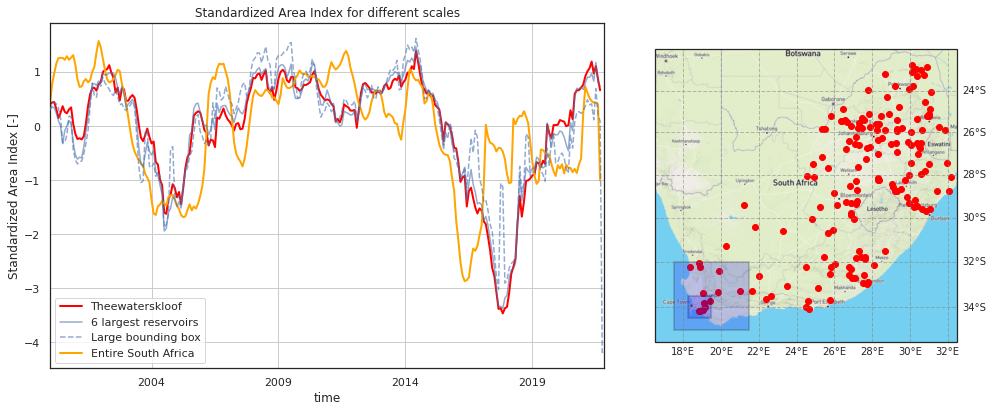

In [37]:

# get one unique reservoir
reservoir_ids = [87663]
df_theewater, df = compute_aggregated_timeseries_sel(reservoir_ids)
df_theewater = df_theewater["2000-01-01":]/1000000
# get reservoirs in small bounding box
xmin, xmax, ymin, ymax = bounds_small
cape = reservoirs_sel#[reservoirs_sel["mean"] > AREA_THRES]
cape = cape[cape.geometry.x < xmax]
cape = cape[cape.geometry.x > xmin]
cape = cape[cape.geometry.y > ymin]
cape = cape[cape.geometry.y < ymax]
reservoir_ids = cape.fid.values
reservoir_ids
df_smallbox, df = compute_aggregated_timeseries_sel(reservoir_ids)

df_smallbox = df_smallbox["2000-01-01":]/1000000

# get the larger bounding box
xmin, xmax, ymin, ymax = bounds_large
cape = reservoirs_sel#[reservoirs_sel["mean"] > AREA_THRES]
cape = cape[cape.geometry.x < xmax]
cape = cape[cape.geometry.x > xmin]
cape = cape[cape.geometry.y > ymin]
cape = cape[cape.geometry.y < ymax]
reservoir_ids = cape.fid.values
reservoir_ids
df_largebox, df = compute_aggregated_timeseries_sel(reservoir_ids)
df_largebox = df_largebox["2000-01-01":]/1000000

# all of south africa
reservoir_ids = reservoirs_sel[reservoirs_sel["mean"] > AREA_THRES].fid.values
reservoir_ids
df_sa, df = compute_aggregated_timeseries_sel(reservoir_ids)
df_sa = df_sa["2000-01-01":]/1000000


# import pdb;pdb.set_trace()
SAI_theewater = compute_standard_index(df_theewater, index=df_theewater.index.month, include_zero=False, dist="norm") 
SAI_smallbox = compute_standard_index(df_smallbox, index=df_smallbox.index.month, include_zero=False, dist="norm")
SAI_largebox = compute_standard_index(df_largebox, index=df_largebox.index.month, include_zero=False, dist="norm")
SAI_sa = compute_standard_index(df_sa, index=df_sa.index.month, include_zero=False, dist="norm")

f = plt.figure(figsize=(14, 6))
ax = f.add_axes([0.1, 0.1, 0.55, 0.8])
SAI_theewater.plot(ax=ax, label="Theewaterskloof", color="red", linewidth=2)
SAI_smallbox.plot(ax=ax, label="6 largest reservoirs", color="b", alpha=0.6, zorder=3)
SAI_largebox.plot(ax=ax, label="Large bounding box", color="b", alpha=0.6, linestyle="--", zorder=3)
SAI_sa.plot(ax=ax, label="Entire South Africa", color="orange", linewidth=2)
ax.set_title("Standardized Area Index for different scales")
# SAI_theewater.plot(ax=ax, label="standardized index")
# area.plot(ax=ax, secondary_y=True, label="original surface area")

lines = ax.get_lines() # + ax.right_ax.get_lines()
ax.legend(lines, [l.get_label() for l in lines])
ax.set_ylabel("Standardized Area Index [-]")
# ax.right_ax.set_ylabel("Storage [km2]")

# ax.right_ax.get_yaxis().set_major_formatter(
#     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid()
# ax2 = f.add_subplot(122)
# df_theewater.plot(ax=ax2, label="Theewaterskloof")
# df_smallbox.plot(ax=ax2, label="Small bounding box")
# df_largebox.plot(ax=ax2, label="Large bounding box")
# df_sa.plot(ax=ax2, label="South Africa")
# lines = ax2.get_lines() # + ax.right_ax.get_lines()
# ax2.legend(lines, [l.get_label() for l in lines])
ax2 = f.add_axes([0.7, 0, 0.3, 1], projection=outdoor.crs)

bounds_large = (17.5, 21.5, -35, -32)
bounds_small = (18.25, 19.5, -34.5, -33.5)
ax2.set_extent([16.5, 32.5, -35.5, -22], crs=ccrs.PlateCarree())
ax2.add_image(outdoor, 6, interpolation='bilinear')
reservoirs_sel[reservoirs_sel["mean"] > AREA_THRES].plot(ax=ax2, transform=ccrs.PlateCarree(), color='red')
xmin, xmax, ymin, ymax = bounds_small
ax2.add_patch(
    mpatches.Rectangle(
        xy=[xmin, ymin], width=xmax-xmin, height=ymax-ymin,
        facecolor='blue',alpha=0.2,
        transform=ccrs.PlateCarree(),
        edgecolor="k",
        linewidth=2.,
    )
)
xmin, xmax, ymin, ymax = bounds_large
ax2.add_patch(
    mpatches.Rectangle(
        xy=[xmin, ymin], width=xmax-xmin, height=ymax-ymin,
        facecolor='blue',alpha=0.2,
        transform=ccrs.PlateCarree(),
        edgecolor="k",
        linewidth=2.,
    )
)


gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

f.savefig("Fig1.png", dpi=300, bbox_inches="tight")


In [38]:
def compute_standard_index(ts, index='time.month', dist='gamma', include_zero=True):
    """
    Compute standardised index (e.g. SPI, SPEI). This is done on monthly time series by:
    - grouping the monthly data into monthly bins
    - for each month fit a distribution function (gamma or gev)
    - estimate the probability of exceedance of each point in the time series using the 12 distributions
    - estimate the normal transform of each probability found using mapping to a standard normal distribution
    Input:
        ts: pandas Series object containing monthly data (e.g. monthly precipitation, precip-ref. evaporation)
        index='time.month': index to use for grouping
        dist='gamma': distribution to use. Currently implemented are 'gamma' (default) and 'gev'.
    """
    # first, we group all values per month. So we get a group of January rainfalls, February rainfalls, etc.
#     import pdb;pdb.set_trace()
    ts_group = ts.groupby(index)
    # for each group, the SPI values are computed and coerced into a new time series. 
    spi = ts_group.apply(fit_and_transform, dist=dist, include_zero=include_zero)
    return spi

reservoirs_large = reservoirs_sel[reservoirs_sel["mean"] > AREA_THRES]
df["2017-05-31":"2017-06-01"]

df_SAI = df.apply(compute_standard_index, axis=0, index=df.index.month, include_zero=False, dist="norm")

In [30]:
df_SAI["2017-05-31":"2017-06-30"]


,area_68743,area_69846,area_70370,area_71652,area_72032,area_72145,area_72411,area_72553,area_72641,area_72646,...,area_84232,area_84526,area_85074,area_85200,area_85358,area_85903,area_85931,area_86753,area_86960,area_87166
time,,,,,,,,,,,,,,,,,,,,,
2017-06-01 00:00:00+00:00,0.660508,-2.272253,1.205572,-1.028464,-2.150091,-1.183788,0.859883,0.70997,0.829861,1.269526,...,0.812107,-0.110999,1.005297,0.578431,-0.264653,-0.94262,-0.279148,0.651518,0.785589,-0.439363


In [88]:
# make new geopandas dataframe with
date2 = datetime(2017, 9, 1)
start_date = "2015-01-01"
end_date = "2021-01-01"

dates = pd.date_range("2015-01-01", "2021-01-01", freq="M")

datestr1 = (date2 - relativedelta(days=1)).strftime("%Y-%m-%d")
datestr2 = date2.strftime("%Y-%m-%d")
a = pd.DatetimeIndex(["2017-08-01"])

from matplotlib.collections import LineCollection
token = 'pk.eyJ1IjoiaGN3aW5zZW1pdXMiLCJhIjoiY2l2MHd3aDN4MDA0OTJ6dDU2Y2F6MWk0dCJ9.mLH0b46r4cHNdb1w9-dLcQ'
outdoor = img_tiles.MapboxStyleTiles(token, 'hcwinsemius', 'ck4ohy7u59mfg1cmi0z2twtll')

In [98]:
a

DatetimeIndex(['2017-08-01'], dtype='datetime64[ns]', freq=None)

In [102]:
SAI_theewater.index.values[0]

numpy.datetime64('2000-01-01T00:00:00.000000000')

In [104]:
a.to_pydatetime()[0]

datetime.datetime(2017, 8, 1, 0, 0)

In [108]:
SAI_theewater[SAI_theewater.index == '2017-08-01']

time
2017-08-01 00:00:00+00:00   -3.083767
dtype: float64

In [119]:
bounds_large = (17.5, 21.5, -35, -32)
bounds_small = (18.25, 19.5, -34.5, -33.5)

countries = {
    "Eswatini": "WZ",
    "South Africa": "SF",
    "Lesotho": "LT",
    "Namibia": "WA",
    "Botswana": "BC",
    "Zimbabwe": "ZI"
}

reservoirs_sel = reservoirs[
    np.any(np.array([
        reservoirs["country_co"] == v for k, v in countries.items()]), axis=0
          )
]


In [120]:
for k, v in countries.items():
    print(k, v)

Eswatini WZ
South Africa SF
Lesotho LT
Namibia WA
Botswana BC
Zimbabwe ZI


In [129]:
def compute_standard_index(ts, index='time.month', dist='gamma', include_zero=True):
    """
    Compute standardised index (e.g. SPI, SPEI). This is done on monthly time series by:
    - grouping the monthly data into monthly bins
    - for each month fit a distribution function (gamma or gev)
    - estimate the probability of exceedance of each point in the time series using the 12 distributions
    - estimate the normal transform of each probability found using mapping to a standard normal distribution
    Input:
        ts: pandas Series object containing monthly data (e.g. monthly precipitation, precip-ref. evaporation)
        index='time.month': index to use for grouping
        dist='gamma': distribution to use. Currently implemented are 'gamma' (default) and 'gev'.
    """
    # first, we group all values per month. So we get a group of January rainfalls, February rainfalls, etc.
#     import pdb;pdb.set_trace()
    ts_group = ts.groupby(index)
    # for each group, the SPI values are computed and coerced into a new time series. 
    spi = ts_group.apply(fit_and_transform, dist=dist, include_zero=include_zero)
    return spi

# reservoirs_large = reservoirs_sel[reservoirs_sel["mean"] > AREA_THRES]
# df["2017-05-31":"2017-06-01"]

df_SAI = df_all.apply(compute_standard_index, axis=0, index=df_all.index.month, include_zero=False, dist="norm")

In [130]:
df_SAI["2017-05-31":"2017-06-30"]


,area_66596,area_67719,area_68388,area_69471,area_70800,area_71455,area_74694,area_77261,area_77516,area_77769,...,area_85638,area_86794,area_78608,area_80665,area_82256,area_84175,area_85073,area_85595,area_85806,area_87859
time,,,,,,,,,,,,,,,,,,,,,
2017-06-01 00:00:00+00:00,0.58662,0.831524,0.95021,0.571212,0.742017,0.884694,0.564909,0.981928,0.937094,0.753206,...,0.680314,0.645936,1.135076,0.922435,1.938791,1.887116,0.936369,-0.263646,1.113798,1.874581


In [127]:
AREA_THRES = 1e6
AREA_THRES_UP = 1e9

# xmin, xmax, ymin, ymax = bounds_small
southern_af = reservoirs_sel[np.all(np.array([reservoirs_sel["mean"] > AREA_THRES, reservoirs_sel["mean"] < AREA_THRES_UP]), axis=0)]
# cape = cape[cape.geometry.x < xmax]
# cape = cape[cape.geometry.x > xmin]
# cape = cape[cape.geometry.y > ymin]
# cape = cape[cape.geometry.y < ymax]
reservoir_ids = southern_af.fid.values
reservoir_ids
df, df_all = compute_aggregated_timeseries_sel(reservoir_ids)


  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

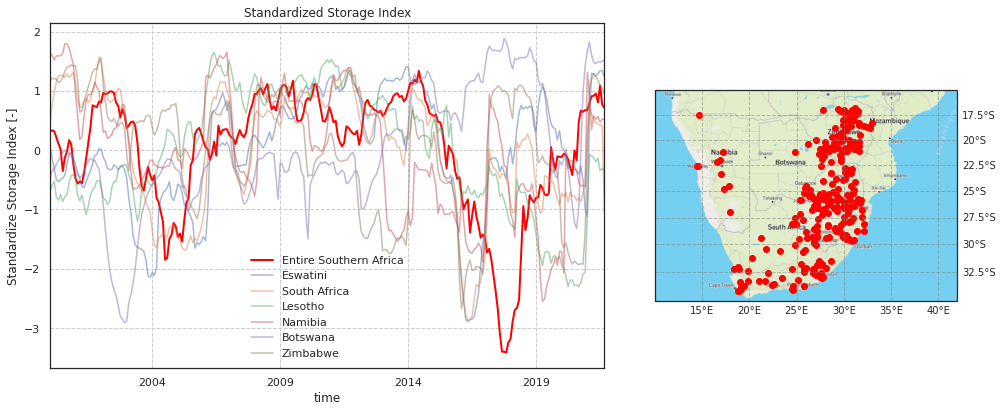

In [134]:
select = {k: compute_aggregated_timeseries_sel(
        southern_af[southern_af["country_co"] == v].fid.values
    )[0]["2000-01-01":] for k, v in countries.items()}

all_reservoirs, df_all = compute_aggregated_timeseries_sel(
        southern_af.fid.values
    )
all_reservoirs = all_reservoirs["2000-01-01":]
df_all = df_all["2000-01-01":]


SAI = compute_standard_index(all_reservoirs, index=all_reservoirs.index.month, include_zero=False, dist="norm") 
select_SAI = {
    k: compute_standard_index(
        select[k],
        index=select[k].index.month,
        include_zero=False,
        dist="norm"
    ) for k in countries
}

plot_kwargs = {
    k: {
        "alpha": 0.5,
    } for k in countries

}

# # get the larger bounding box
# xmin, xmax, ymin, ymax = bounds_large
# cape = reservoirs_sel#[reservoirs_sel["mean"] > AREA_THRES]
# cape = cape[cape.geometry.x < xmax]
# cape = cape[cape.geometry.x > xmin]
# cape = cape[cape.geometry.y > ymin]
# cape = cape[cape.geometry.y < ymax]
# reservoir_ids = cape.fid.values
# reservoir_ids
# df_largebox, df = compute_aggregated_timeseries_sel(reservoir_ids)
# df_largebox = df_largebox["2000-01-01":]/1000000

# # all of south africa
# reservoir_ids = reservoirs_sel[reservoirs_sel["mean"] > AREA_THRES].fid.values
# reservoir_ids
# df_sa, df = compute_aggregated_timeseries_sel(reservoir_ids)
# df_sa = df_sa["2000-01-01":]/1000000

# # import pdb;pdb.set_trace()
# SSI_zimbabwe = compute_standard_index(df_zimbabwe, index=df_theewater.index.month, include_zero=False, dist="norm") 

f = plt.figure(figsize=(14, 6))
ax = f.add_axes([0.1, 0.1, 0.55, 0.8])
SSI.plot(ax=ax, label="Entire Southern Africa", color="red", linewidth=2)
for k in countries:
    select_SAI[k].plot(ax=ax, label=k, **plot_kwargs[k])
ax.set_title("Standardized Storage Index")
# SSI_theewater.plot(ax=ax, label="standardized index")
# area.plot(ax=ax, secondary_y=True, label="original surface area")

lines = ax.get_lines() # + ax.right_ax.get_lines()
ax.legend(lines, [l.get_label() for l in lines], framealpha=0.)
ax.set_ylabel("Standardize Storage Index [-]")
ax.grid(linestyle="--")
ax2 = f.add_axes([0.7, 0, 0.3, 1], projection=outdoor.crs)

ax2.set_extent([10, 42, -35, -15], crs=ccrs.PlateCarree())
ax2.add_image(outdoor, 5, interpolation='bilinear')
reservoirs_sel[reservoirs_sel["mean"] > AREA_THRES].plot(ax=ax2, transform=ccrs.PlateCarree(), color='red')
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# f.savefig("Figx.png", dpi=300, bbox_inches="tight")


In [137]:
a.to_pydatetime()

array([datetime.datetime(2016, 4, 1, 0, 0)], dtype=object)

In [144]:
SAI[SAI.index == str(a.to_pydatetime()[0])]

time
2016-04-01 00:00:00+00:00   -2.699271
Freq: MS, dtype: float64

(-3.12968066565251, 2.124173514219384)
DatetimeIndex(['2016-04-01'], dtype='datetime64[ns]', freq=None)


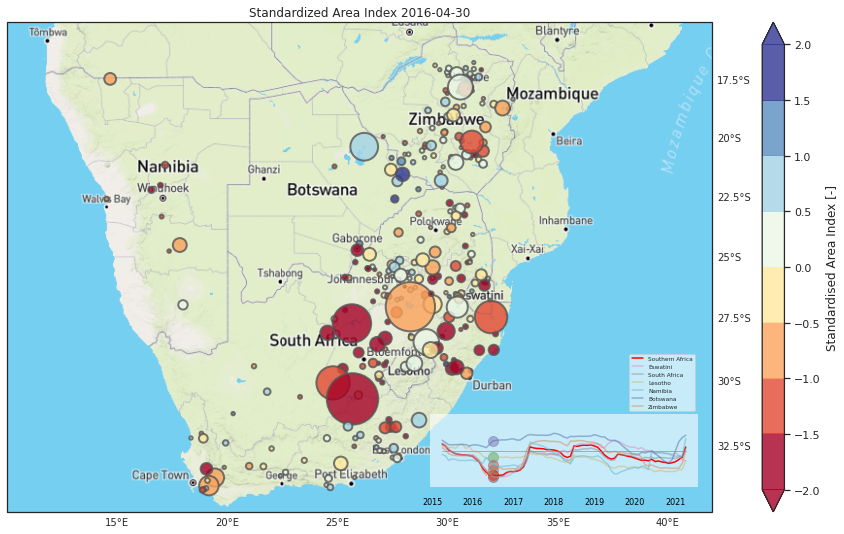

In [178]:
# make new geopandas dataframe with
date2 = datetime(2016, 5, 1)
start_date = "2015-01-01"
end_date = "2021-01-01"

dates = pd.date_range("2015-01-01", "2021-01-01", freq="M")


datestr1 = (date2 - relativedelta(days=1)).strftime("%Y-%m-%d")
datestr2 = date2.strftime("%Y-%m-%d")
a = pd.DatetimeIndex(["2016-04-01"])

from matplotlib.collections import LineCollection
token = 'pk.eyJ1IjoiaGN3aW5zZW1pdXMiLCJhIjoiY2l2MHd3aDN4MDA0OTJ6dDU2Y2F6MWk0dCJ9.mLH0b46r4cHNdb1w9-dLcQ'
outdoor = img_tiles.MapboxStyleTiles(token, 'hcwinsemius', 'ck4ohy7u59mfg1cmi0z2twtll')
f = plt.figure(figsize=(18, 10), frameon=False)
ax = plt.subplot(111, projection=outdoor.crs)
ax.set_extent([10, 42, -35, -15], crs=ccrs.PlateCarree())
ax.add_image(outdoor, 5, interpolation='bilinear')
bounds = np.linspace(-2., 2., 9)
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
p = ax.scatter(
    southern_af.geometry.x,
    southern_af.geometry.y,
    s=southern_af["mean"]/1e5,
    c=df_SAI[datestr1:datestr2].values.flatten(),
    transform=ccrs.PlateCarree(),
    alpha=0.8,
    cmap="RdYlBu",
    norm=norm,
    edgecolor="#555555",
    linewidth=2,
)



gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0., linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
cb = plt.colorbar(p, extend="both")
cb.set_label("Standardised Area Index [-]")
title = plt.title(f"Standardized Area Index {datestr1}")

# add time series inset
ax_inset = ax.inset_axes([0.6, 0.05, 0.38, 0.15])

# # plot a time slider
# ax_inset.plot([a, a], [-3, 3], 'r', linewidth=6, alpha=1)
m1 = ax_inset.plot(a, SAI[SAI.index == str(a.to_pydatetime()[0])], label="Southern Africa", marker=".", color='red', markersize=20)
m = [ax_inset.plot(a, select_SAI[k][SAI.index == str(a.to_pydatetime()[0])], label=k, marker=".", markersize=20, **plot_kwargs[k]) for k in countries]
SAI[start_date:end_date].plot(ax=ax_inset, label="Southern Africa", color="red")
[select_SAI[k][start_date:end_date].plot(ax=ax_inset, label=k, **plot_kwargs[k]) for k in countries]
i = SAI[start_date:end_date].index
pd.DataFrame({"zero_ax": np.zeros(len(i))}, index=i).plot(color="#888888", linewidth=0.6, ax=ax_inset, legend=False)
# pd.DataFrame({"one_ax": np.zeros(len(dates))-1}, index=SAI_theewater[start_date:end_date].index).plot(color="#AAAAAA", linewidth=0.6, linestyle="--", ax=ax_inset, legend=False)
# pd.DataFrame({"one_ax": np.zeros(len(dates))+1}, index=SAI_theewater[start_date:end_date].index).plot(color="#AAAAAA", linewidth=0.6, linestyle="--", ax=ax_inset, legend=False)

# SAI_smallbox.plot(ax=ax, label="Small bounding box")
# SAI_largebox.plot(ax=ax, label="Large bounding box")
# SAI_sa[start_date:end_date].plot(ax=ax_inset, label="South Africa", color='orange')
# m2, = ax_inset.plot(a, SAI_sa[a], label="South Africa", marker=".", color='orange', markersize=20)
b = ax_inset.get_ylim()
print(b)
print(a)
lines = ax_inset.get_lines() # + ax.right_ax.get_lines()
lines = lines[-(len(countries)+2):-1]
leg = ax_inset.legend(
    lines,
    [l.get_label() for l in lines],
    bbox_to_anchor=(1, 1),
    loc='lower right',
    fontsize="xx-small",
    framealpha=0.6,
)

ax_inset.set_ylabel("Standardize Area Index [-]")
# ax.right_ax.set_ylabel("Storage [km2]")
ax_inset.set_xlabel("")
ax_inset.set_ylabel("")
ax_inset.patch.set_alpha(0.6)
ax_inset.set_ylim([-4, 4])
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)
ax_inset.spines['bottom'].set_visible(False)
ax_inset.spines['left'].set_visible(False)
ax_inset.tick_params(axis='both', colors='black')
# ax_inset.grid(color='k', linestyle='-', linewidth=1, alpha=0.5)
# dummy = ax_inset.set_xticklabels([])
dummy = ax_inset.set_yticklabels([])
ax_inset.tick_params(axis='x', labelsize=8)
ax_inset.set_xticklabels(['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'], rotation = 0)


# ax_inset.axis("off")
# ax.right_ax.get_yaxis().set_major_formatter(
#     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
f.savefig("Fig2.png", dpi=300, bbox_inches="tight")

In [43]:
def plot_monthly_qq(ts, index='time.month', dist='gamma', include_zero=True):
    """
    Input:
        ts: pandas Series object containing monthly data (e.g. monthly precipitation, precip-ref. evaporation)
        index='time.month': index to use for grouping
        dist='gamma': distribution to use. Currently implemented are 'gamma' (default) and 'gev'.
    """
    # first, we group all values per month. So we get a group of January rainfalls, February rainfalls, etc.
    ts_group = ts.groupby(index)
    f = plt.figure(figsize=(16, 14))
    for group in list(ts_group):
        month = group[0]
        ax = plt.subplot(4, 3, int(month))
        ts = group[-1]
        # make qq plot based on chosen distribution
        fit_params, prob_zero = fit(ts, dist=dist, include_zero=include_zero)
        # get sorted data and empirical plot positions
        data = ts.to_numpy().flatten()
        data.sort()
        plot_pos = np.arange(0, len(data))/(len(data)+1)
        # get plot positions based on fit data
        dist_func = getattr(stats, dist)
        q = dist_func.cdf(data, *fit_params)
        plt.plot(plot_pos, q, '.')
        # print 1:1 line
        plt.plot([0, 1], [0, 1], 'r')
        plt.title(f"Month {month}")
        if (month-1) % 3 == 0:
            plt.ylabel("Q fitted [-]")
        if month > 9:
            plt.xlabel("Q empirical [-]")
        plt.grid()
    # for each group, the SPI values are computed and coerced into a new time series. 


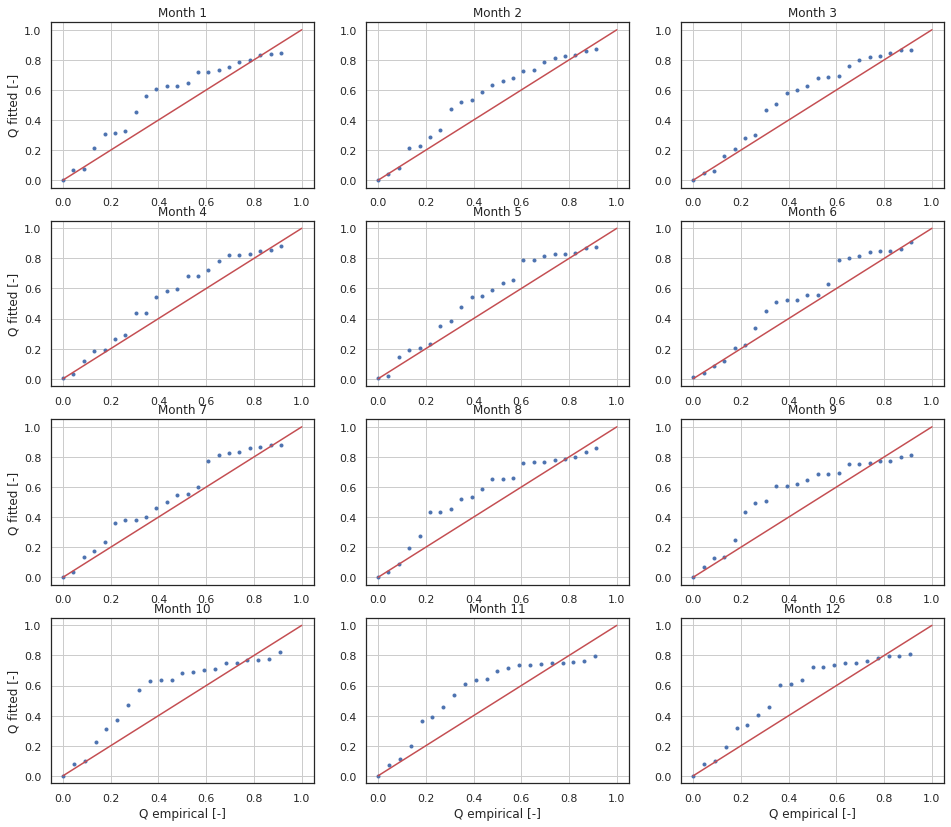

In [44]:
plot_monthly_qq(area, index=area.index.month, dist="norm")